In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing import image
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder

from tensorflow.keras import layers, metrics
from tensorflow.keras.models  import Sequential, load_model
from tensorflow.keras.metrics import Accuracy, AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Input, Activation
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score

Görüntü path'lerini ve label'larını dataframe'e çevirelim.

In [2]:
label = []
path = []
fish_dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset/'
for dir_name, _, filenames in os.walk(fish_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1]==".png":
            if dir_name.split()[-1]!="GT":
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))
data =pd.DataFrame(columns=["path","label"])
data["path"]=path
data["label"]=label


In [3]:
data.head()

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel


Kaç adet sınıf olduğuna bakalım.

In [4]:
data["label"].nunique()

9

Her bir sınıftaki gözlem sayısını inceleyelim. Normal dağılımlı bir veri olduğu görülüyor.

In [5]:
data["label"].value_counts()

label
Hourse Mackerel       1000
Black Sea Sprat       1000
Sea Bass              1000
Red Mullet            1000
Trout                 1000
Striped Red Mullet    1000
Shrimp                1000
Gilt-Head Bream       1000
Red Sea Bream         1000
Name: count, dtype: int64

X_path ve y değişkenlerini ayıralım.

In [6]:
X_path = data["path"]
y = data["label"]

Pathlerdeki görüntüleri okutup array'a çevirelim ve X olarak atayalım. X'den bir gözlemi görelim.

In [7]:
X =[]
for path in X_path:
    img = image.load_img(path, target_size=(224,224))
    img_array = image.img_to_array(img)
    X.append(img_array)

print(X[0:1])

[array([[[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       ...,

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]],

       [[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        ...,
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]], dtype=float32)]


X ve y'leri işlemleri rahat yapabilmek adına numpy array'ine dönüştürelim.

In [8]:
X = np.array(X)
y = np.array(y)

In [9]:
print(len(X))
print(len(y))

9000
9000


In [10]:
print(X.shape)
print(y.shape)

(9000, 224, 224, 3)
(9000,)


In [11]:
# Görselleri normalize edelim
X = X / 255

In [12]:
y[0:3]

array(['Hourse Mackerel', 'Hourse Mackerel', 'Hourse Mackerel'],
      dtype=object)

In [13]:
#Veri(y) 1D boyutunda olduğu için one-hot encoderda hata alıyoruz. 2D şekline dönüştürelim
y = y.reshape(-1, 1)

In [14]:
y[0:3]

array([['Hourse Mackerel'],
       ['Hourse Mackerel'],
       ['Hourse Mackerel']], dtype=object)

In [15]:
#labelları one-hot encode edelim. ilk 3 değeri gözlemleyelim.
encoder = OneHotEncoder(sparse=False)  # sparse=False ile dense matris oluşturur (daha anlaşılır görüntüleme için)

y = encoder.fit_transform(y)
y[0:3]

/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([[0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [16]:
print(X.shape)
print(y.shape)

(9000, 224, 224, 3)
(9000, 9)


Train, valisayon ve test setleri oluşturalım. Verinin her bir kümeye homojen dağılımı olsun diye shuffle uygulayalım.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=13)

In [18]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=13)

In [19]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(5760, 224, 224, 3)
(5760, 9)
(1440, 224, 224, 3)
(1440, 9)


Train setine veri çoğaltma işlemleri uygulayalım. Daha önceden ölçeklendirme yaptığımız için burada rescale parametresini kullanmadık.

train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow(X_train, y_train, batch_size=128)

Model mimarisini oluşturalım.

In [20]:
model = Sequential([
    layers.Input(shape=(224,224,3)),
    layers.Flatten(),
    layers.Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    layers.Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    layers.Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    layers.Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    Dropout(0.2),
    layers.Dense(256, activation="relu", kernel_regularizer=l2(0.001)),
    BatchNormalization(),
    layers.Dense(9, activation="softmax")]
)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=["accuracy", "AUC"])

In [21]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=10,
                               verbose=1,
                               restore_best_weights=True, 
                               mode="min")

model_checkpoint = ModelCheckpoint(filepath='fish_model2.keras',
                             monitor='val_loss',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)

In [22]:
start_time = datetime.datetime.now()

history = model.fit(X_train, y_train,
                    epochs = 100,
                    validation_data = (X_val, y_val),
                    batch_size= 128,
                    callbacks =[early_stopping, model_checkpoint]
         )

end_time = datetime.datetime.now()
total_duration = end_time - start_time
print("Trainin Time:", total_duration)

Epoch 1/100


I0000 00:00:1731739407.630032      68 service.cc:145] XLA service 0x7fadbc009150 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731739407.630128      68 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1731739407.630136      68 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 3/45 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - AUC: 0.5249 - accuracy: 0.1259 - loss: 4.3538 

I0000 00:00:1731739417.086058      68 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - AUC: 0.6209 - accuracy: 0.2053 - loss: 3.9721
Epoch 1: val_loss improved from inf to 4.83906, saving model to fish_model2.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 20s 140ms/step - AUC: 0.6223 - accuracy: 0.2065 - loss: 3.9666 - val_AUC: 0.5861 - val_accuracy: 0.1222 - val_loss: 4.8391
Epoch 2/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - AUC: 0.7993 - accuracy: 0.4025 - loss: 3.2691
Epoch 2: val_loss improved from 4.83906 to 3.69689, saving model to fish_model2.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - AUC: 0.7997 - accuracy: 0.4029 - loss: 3.2675 - val_AUC: 0.6937 - val_accuracy: 0.2486 - val_loss: 3.6969
Epoch 3/100
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - AUC: 0.8590 - accuracy: 0.4896 - loss: 2.9718
Epoch 3: val_loss improved from 3.69689 to 3.35230, saving model to fish_model2.keras
45/45 ━━━━━━━━━━━━━━━━━━━━ 4s 93ms/step - AUC: 0.8593 - accuracy: 0.4901 - loss: 2.9702 - val_AUC: 0.7644 - val_accuracy: 0.3250 - val_loss: 3.3523
Epoch 4/100

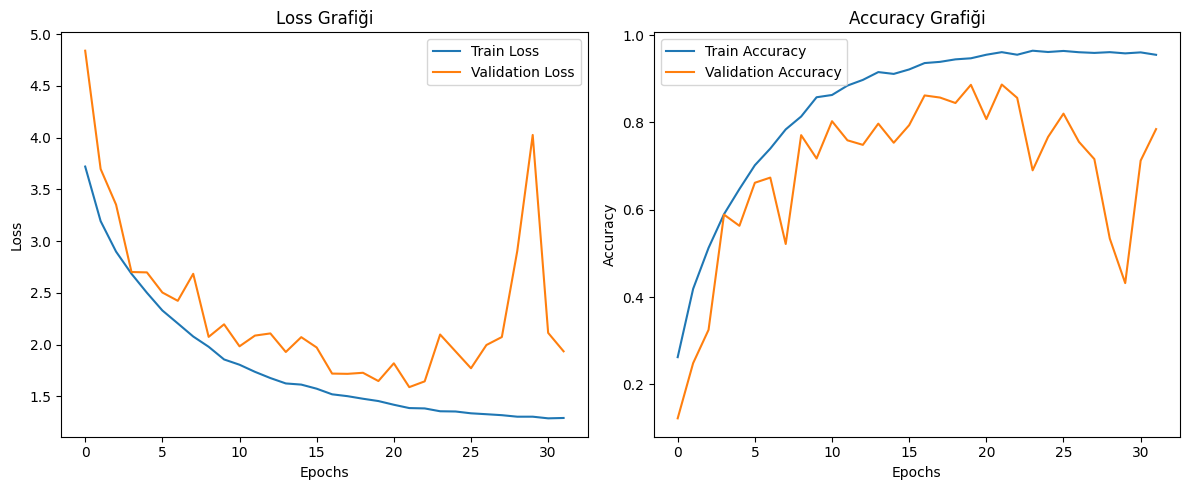

In [23]:
# Eğitim sonuçlarını görselleştirelim
plt.figure(figsize=(12, 5))

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Grafiği')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [24]:
val_loss, val_accuracy, val_auc = model.evaluate(X_val, y_val, verbose=0)
print(f"Loss: {val_loss}")
print(f"Accuracy: {val_accuracy}")
print(f"AUC: {val_auc}")

Loss: 1.5899004936218262
Accuracy: 0.886805534362793
AUC: 0.991287887096405


In [25]:
# Test seti üzerinde tahmin yapalım.
y_pred = model.predict(X_test)

# En yüksek olasılığı bulup sınıf indeksine çevirelim.
y_pred_classes = y_pred.argmax(axis=-1)

# Gerçek etiketler one-hot encode edilmiş halde, bu yüzden onları da sınıf indekslerine dönüştürelim.
y_test = np.array(y_test) # test seti ile tahmin sunuçlarının veri tipi farklı olduğu için test setini de np array'e çevirelim.
y_test_classes = y_test.argmax(axis=-1)

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [26]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Çok sınıflı sınıflandırma için precision, recall, F1 score hesaplama average="weighted" ifadesi ile sınıf dağılımlarına göre ağırıklı ort. alır. 
accuracy = accuracy_score(y_test_classes, y_pred_classes)
precision = precision_score(y_test_classes, y_pred_classes, average='weighted')
recall = recall_score(y_test_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')

print(f'Weighted Accuracy: {accuracy}')
print(f'Weighted Precision: {precision}')
print(f'Weighted Recall: {recall}')
print(f'Weighted F1 Score: {f1}')

Weighted Accuracy: 0.8777777777777778
Weighted Precision: 0.8952293456029803
Weighted Recall: 0.8777777777777778
Weighted F1 Score: 0.8791265133477679
